# PA005: High Value Customer Identification

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [2]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [4]:
# load data
df_raw = pd.read_csv('./datasets/Ecommerce.csv', encoding='latin-1')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='red'> 1.0. Descrição dos dados </font>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
# remova na
df1 = df1.dropna( subset=['description', 'customer_id'] )
print( 'Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtypes

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7. Descriptive Statistics

# <font color='red'> 2.0. Feature Engineering </font>

In [14]:
df2 = df1.copy()

## 2.1. Feature Creation

In [15]:
# data reference
df_ref = df2.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

# Gross Revenue ( Faturamento ) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# <font color='red'> 3.0. Filtragem de Varivéis </font>

In [16]:
df3 = df_ref.copy()

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [17]:
df4 = df3.copy()

# <font color='red'> 5.0. Data Preparation </font>

In [18]:
df5 = df4.copy()

# <font color='red'> 6.0. Feature Selection </font>

In [19]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [20]:
X = df6.drop( columns=['customer_id'] )

In [21]:
X.head()

,gross_revenue,recency_days,invoice_no
0,5288.63,302,35
1,3079.10,31,18
2,7187.34,2,18
3,948.25,95,5
4,635.10,330,6


In [22]:
clusters = [2, 3, 4, 5, 6]

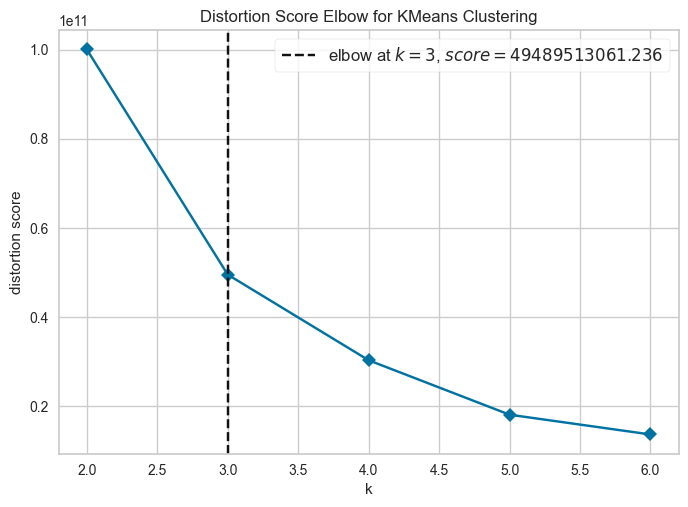

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

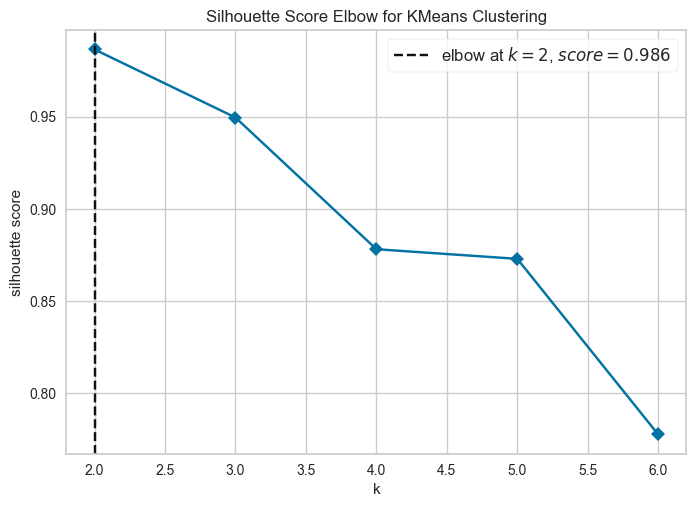

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [24]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 7.1 Within-Cluster Sum of Square (WSS)

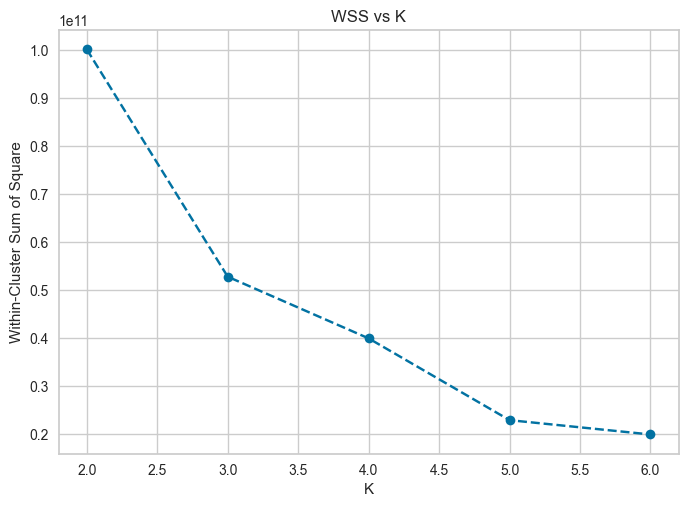

In [25]:
wss = []

for k in clusters:
    # Model definition
    kmeans = c.KMeans( init='random' , n_clusters=k, n_init=10, max_iter=300, random_state=42 )
    
    # Model training
    kmeans.fit( X )
    
    # Validation
    wss.append( kmeans.inertia_ )

# plot wss - Elbow Method
plt.plot( clusters, wss, linestyle='--', marker='o', color='b' );
plt.xlabel( 'K' );
plt.ylabel( 'Within-Cluster Sum of Square' );
plt.title( 'WSS vs K' );

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [26]:
# model definition
k = 5
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

### 8.2. Cluster Validation

In [27]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 22956286930.931786
SS value: 0.7734960328917805


# <font color='red'> 9.0. Cluster Analysis </font>

In [28]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,1
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,1
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


## 9.1. Visualization Inspection

In [29]:
fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
fig.show()


KeyboardInterrupt



## 9.2. Cluster Profile

In [ ]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,3
1,13047,3079.10,31,18,2
2,12583,7187.34,2,18,3
3,13748,948.25,95,5,2
4,15100,635.10,330,6,2


In [ ]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,15,0.343092,71423.516000,7.400000,67.866667
1,1,38,0.869167,23181.925000,12.868421,43.078947
2,2,3896,89.112534,817.913748,99.906057,3.322382
3,3,420,9.606587,5804.281619,25.119048,15.230952
4,4,3,0.068618,241136.560000,3.000000,64.666667


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.71 do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares

# <font color='red'> 10.0. Deploy To Production </font>